# Overall Comments
- realized that pixel classification was a potential approach as inspired by the color detection and Canny edge method I had from the toy image last week
- Small pixel noise in epithelium layer being detected as interior stroma with an extraction like this
- attempted primative method for pixel classification, algorithm will attempt 100 times to take a good sample and then output if all pixel colors are detected
- **last code cell creates patches of all same size on the epithelium -- will work on stroma + exterior inclusion next week**
- worked together with Kevin pivoted to use his super pixel segmentation image which has a completely white interior stroma

# View Kevin's Code for the combined algorithm from our week 3 codes

# Presentation 4 - Pixel classification for patches

Attempt: 1 | Black Pixels: 0 | Magenta Pixels: 1176 | Stroma Pixels: 2721
Attempt: 2 | Black Pixels: 5220 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 3 | Black Pixels: 4588 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 4 | Black Pixels: 3712 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 5 | Black Pixels: 609 | Magenta Pixels: 1154 | Stroma Pixels: 955
Attempt: 1 | Black Pixels: 2208 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 2 | Black Pixels: 7520 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 3 | Black Pixels: 0 | Magenta Pixels: 330 | Stroma Pixels: 2023
Attempt: 4 | Black Pixels: 3360 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 5 | Black Pixels: 2315 | Magenta Pixels: 1093 | Stroma Pixels: 967
Attempt: 1 | Black Pixels: 2074 | Magenta Pixels: 52 | Stroma Pixels: 416
Attempt: 1 | Black Pixels: 4187 | Magenta Pixels: 29 | Stroma Pixels: 40
Attempt: 2 | Black Pixels: 6660 | Magenta Pixels: 0 | Stroma Pixels: 0
Attempt: 3 | Black Pixels: 3496 | Magenta Pixels: 0 | Stro

<Figure size 1200x800 with 0 Axes>

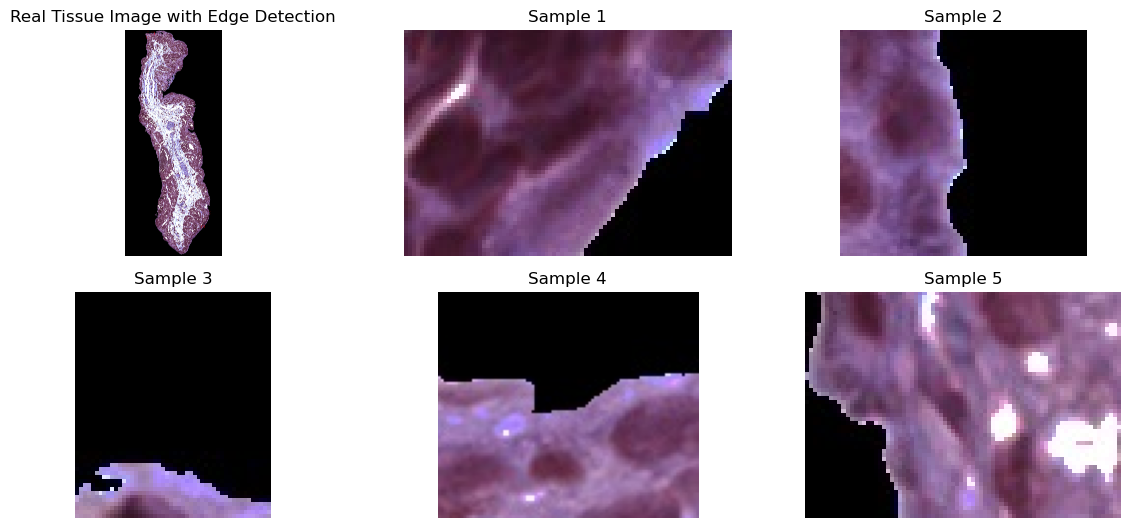

In [20]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

image_with_cells_path = 'FinalExtraction.jpg'  
image_with_cells = cv2.imread(image_with_cells_path)


image_rgb_with_cells = cv2.cvtColor(image_with_cells, cv2.COLOR_BGR2RGB)

# Refine the edge detection sampling function to handle the real tissue with noisy stroma
def refined_edge_detection_sample_tissue(image, num_samples=5, min_size=(40, 40), max_size=(100, 100)):
    # Convert the image to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    
    height, width = image.shape[:2]
    samples = []
    sample_coords = []
    
    for _ in range(num_samples):
        attempts = 0
        while attempts < 100:  # Limit attempts to avoid endless loop
            attempts += 1
            
            # Randomly pick a point in the black area (outer region) and try to extend the sample to include the epithelium and stroma
            center_x = random.randint(min_size[0] // 2, width - min_size[0] // 2)
            center_y = random.randint(min_size[1] // 2, height - min_size[1] // 2)

            # Define the sample box
            sample_width = random.randint(min_size[0], max_size[0])
            sample_height = random.randint(min_size[1], max_size[1])
            x1 = max(0, center_x - sample_width // 2)
            y1 = max(0, center_y - sample_height // 2)
            x2 = min(width, center_x + sample_width // 2)
            y2 = min(height, center_y + sample_height // 2)
            
            # Crop the sample and check edge detection within the box
            sample_rgb = image[y1:y2, x1:x2]
            sample_edges = edges[y1:y2, x1:x2]
            
            # Detect the exterior black, magenta epithelium, and interior stroma
            black_pixels = np.sum(np.all(sample_rgb == [0, 0, 0], axis=-1))  # Black exterior
            magenta_pixels = np.sum((sample_rgb[:, :, 0] > 100) & (sample_rgb[:, :, 1] < 100) & (sample_rgb[:, :, 2] > 100))  # Magenta epithelium
            stroma_pixels = np.sum((sample_rgb[:, :, 0] > 120) & (sample_rgb[:, :, 2] > 120))  # Looser range for noisy blue/indigo stroma
            
            # Print the detected pixel counts for debugging
            print(f"Attempt: {attempts} | Black Pixels: {black_pixels} | Magenta Pixels: {magenta_pixels} | Stroma Pixels: {stroma_pixels}")

            # Check that the sample contains a reasonable amount of each region
            if np.sum(sample_edges) > 100 and black_pixels > 50 and magenta_pixels > 50 and stroma_pixels > 50:
                samples.append(sample_rgb)
                sample_coords.append((x1, y1, x2, y2))
                break
    
    return samples, sample_coords

# Use the refined sampling method for the real tissue image
samples_with_cells, sample_coords_with_cells = refined_edge_detection_sample_tissue(
    image_rgb_with_cells, num_samples=5, min_size=(40, 40), max_size=(100, 100))

# Draw red boxes around the sample areas on the test image
image_with_cells_and_boxes = image_rgb_with_cells.copy()
for (x1, y1, x2, y2) in sample_coords_with_cells:
    cv2.rectangle(image_with_cells_and_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red box

# Plot the overall image with red boxes and the individual samples
plt.figure(figsize=(12, 8))

num_samples = len(samples_with_cells)
cols = 3  # Number of columns
rows = (num_samples + 1) // cols + 1  # Dynamically calculate rows based on number of samples

plt.figure(figsize=(12, 8))

# Plot the full image with sample boxes
plt.subplot(rows, cols, 1)
plt.imshow(image_with_cells_and_boxes)
plt.title("Real Tissue Image with Edge Detection")
plt.axis('off')

# Plot each sample in its own subplot
for i, sample in enumerate(samples_with_cells):
    plt.subplot(rows, cols, i + 2)
    plt.imshow(sample)
    plt.title(f"Sample {i + 1}")
    plt.axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## refining stroma detection w/ masking

Attempt: 1 | Black Pixels: 6992 | Magenta Pixels: 0 | Stroma Pixels (Isolated): 0
Attempt: 2 | Black Pixels: 4535 | Magenta Pixels: 911 | Stroma Pixels (Isolated): 0
Attempt: 3 | Black Pixels: 0 | Magenta Pixels: 922 | Stroma Pixels (Isolated): 9291
Attempt: 4 | Black Pixels: 9752 | Magenta Pixels: 0 | Stroma Pixels (Isolated): 0
Attempt: 5 | Black Pixels: 0 | Magenta Pixels: 1784 | Stroma Pixels (Isolated): 0
Attempt: 6 | Black Pixels: 5776 | Magenta Pixels: 0 | Stroma Pixels (Isolated): 0
Attempt: 7 | Black Pixels: 5220 | Magenta Pixels: 0 | Stroma Pixels (Isolated): 0
Attempt: 8 | Black Pixels: 0 | Magenta Pixels: 566 | Stroma Pixels (Isolated): 0
Attempt: 9 | Black Pixels: 12540 | Magenta Pixels: 0 | Stroma Pixels (Isolated): 0
Attempt: 10 | Black Pixels: 0 | Magenta Pixels: 348 | Stroma Pixels (Isolated): 9102
Attempt: 11 | Black Pixels: 0 | Magenta Pixels: 1451 | Stroma Pixels (Isolated): 0
Attempt: 12 | Black Pixels: 2960 | Magenta Pixels: 0 | Stroma Pixels (Isolated): 0
Attempt

<Figure size 1200x800 with 0 Axes>

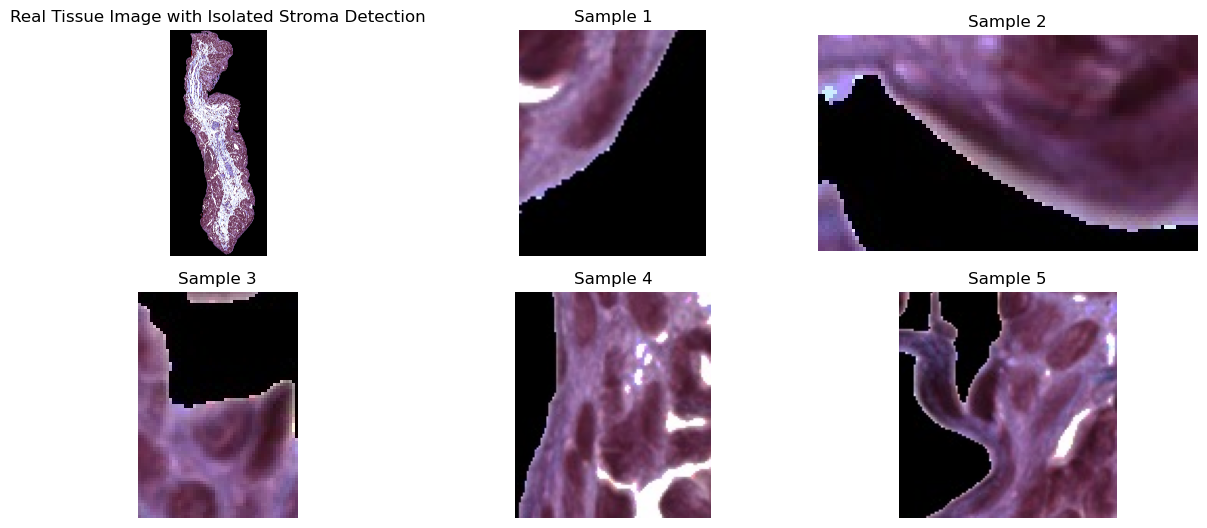

In [24]:
# Refine the stroma detection and balance the sample composition more effectively
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the real tissue image
image_with_cells_path = 'FinalExtraction.jpg'  # Path to the real tissue image
image_with_cells = cv2.imread(image_with_cells_path)

# Convert the image to RGB for processing
image_rgb_with_cells = cv2.cvtColor(image_with_cells, cv2.COLOR_BGR2RGB)

# Refine the edge detection sampling function to handle the real tissue with isolated stroma detection
def isolated_stroma_detection_sample(image, num_samples=5, min_size=(100, 100), max_size=(120, 120)):
    # Convert the image to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    
    height, width = image.shape[:2]
    samples = []
    sample_coords = []
    
    for _ in range(num_samples):
        attempts = 0
        while attempts < 100:  # Limit attempts to avoid endless loop
            attempts += 1
            
            # Randomly pick a point in the black area (outer region) and try to extend the sample to include the epithelium and stroma
            center_x = random.randint(min_size[0] // 2, width - min_size[0] // 2)
            center_y = random.randint(min_size[1] // 2, height - min_size[1] // 2)

            # Define the sample box
            sample_width = random.randint(min_size[0], max_size[0])
            sample_height = random.randint(min_size[1], max_size[1])
            x1 = max(0, center_x - sample_width // 2)
            y1 = max(0, center_y - sample_height // 2)
            x2 = min(width, center_x + sample_width // 2)
            y2 = min(height, center_y + sample_height // 2)
            
            # Crop the sample and check edge detection within the box
            sample_rgb = image[y1:y2, x1:x2]
            sample_edges = edges[y1:y2, x1:x2]
            
            # Detect the exterior black, magenta epithelium, and interior stroma
            black_pixels = np.sum(np.all(sample_rgb == [0, 0, 0], axis=-1))  # Black exterior
            magenta_pixels = np.sum((sample_rgb[:, :, 0] > 100) & (sample_rgb[:, :, 1] < 100) & (sample_rgb[:, :, 2] > 100))  # Magenta epithelium
            stroma_pixels = np.sum((sample_rgb[:, :, 0] > 120) & (sample_rgb[:, :, 2] > 120) & (sample_rgb[:, :, 1] < 180))  # Looser range for noisy blue/indigo stroma

            # Add a mask to avoid counting small white pixels in the epithelium as stroma
            non_epithelium_mask = (sample_rgb[:, :, 1] > 100) | (sample_rgb[:, :, 0] < 100)  # Avoid white bits in magenta
            stroma_pixels = np.sum(stroma_pixels & non_epithelium_mask)

            # Print the detected pixel counts for debugging
            print(f"Attempt: {attempts} | Black Pixels: {black_pixels} | Magenta Pixels: {magenta_pixels} | Stroma Pixels (Isolated): {stroma_pixels}")

            # Check that the sample contains a reasonable amount of each region, and balance stroma detection
            if np.sum(sample_edges) > 100 and black_pixels > 50 and magenta_pixels > 50 and stroma_pixels > 50:
                samples.append(sample_rgb)
                sample_coords.append((x1, y1, x2, y2))
                break
    
    return samples, sample_coords

# Use the refined sampling method for the real tissue image
samples_with_cells, sample_coords_with_cells = isolated_stroma_detection_sample(
    image_rgb_with_cells, num_samples=5, min_size=(40, 40), max_size=(120, 120))

# Draw red boxes around the sample areas on the test image
image_with_cells_and_boxes = image_rgb_with_cells.copy()
for (x1, y1, x2, y2) in sample_coords_with_cells:
    cv2.rectangle(image_with_cells_and_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red box

# Plot the overall image with red boxes and the individual samples
plt.figure(figsize=(12, 8))

num_samples = len(samples_with_cells)
cols = 3  # Number of columns
rows = (num_samples + 1) // cols + 1  # Dynamically calculate rows based on number of samples

plt.figure(figsize=(12, 8))

# Plot the full image with sample boxes
plt.subplot(rows, cols, 1)
plt.imshow(image_with_cells_and_boxes)
plt.title("Real Tissue Image with Isolated Stroma Detection")
plt.axis('off')

# Plot each sample in its own subplot
for i, sample in enumerate(samples_with_cells):
    plt.subplot(rows, cols, i + 2)
    plt.imshow(sample)
    plt.title(f"Sample {i + 1}")
    plt.axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Fixed patch size based on stakeholder comments

<Figure size 1200x800 with 0 Axes>

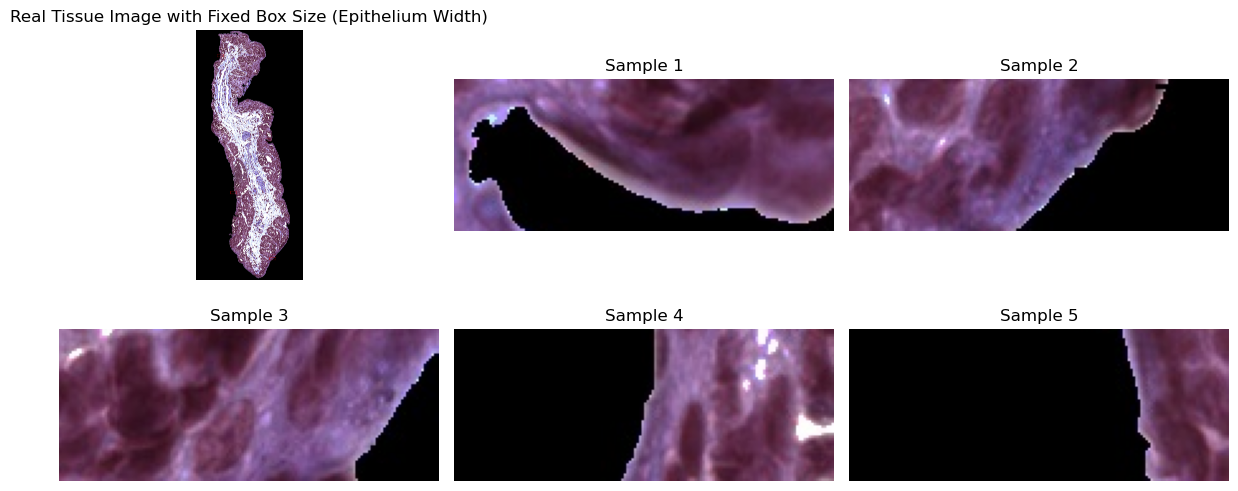

In [27]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the real tissue image
image_with_cells_path = 'FinalExtraction.jpg'  # Path to the real tissue image
image_with_cells = cv2.imread(image_with_cells_path)

# Convert the image to RGB for processing
image_rgb_with_cells = cv2.cvtColor(image_with_cells, cv2.COLOR_BGR2RGB)

# Refine the edge detection sampling function with fixed box size
def fixed_box_epithelium_sample(image, num_samples=5, box_size=(150, 60)):
    # Convert the image to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    
    height, width = image.shape[:2]
    samples = []
    sample_coords = []
    
    sample_width, sample_height = box_size
    
    for _ in range(num_samples):
        attempts = 0
        while attempts < 100:  # Limit attempts to avoid endless loop
            attempts += 1
            
            # Randomly pick a point in the black area (outer region) and try to extend the sample to include the epithelium and stroma
            center_x = random.randint(sample_width // 2, width - sample_width // 2)
            center_y = random.randint(sample_height // 2, height - sample_height // 2)

            # Define the sample box with fixed dimensions for the epithelium width
            x1 = max(0, center_x - sample_width // 2)
            y1 = max(0, center_y - sample_height // 2)
            x2 = min(width, center_x + sample_width // 2)
            y2 = min(height, center_y + sample_height // 2)
            
            # Crop the sample and check edge detection within the box
            sample_rgb = image[y1:y2, x1:x2]
            sample_edges = edges[y1:y2, x1:x2]
            
            # Detect the exterior black, magenta epithelium, and interior stroma
            black_pixels = np.sum(np.all(sample_rgb == [0, 0, 0], axis=-1))  # Black exterior
            magenta_pixels = np.sum((sample_rgb[:, :, 0] > 100) & (sample_rgb[:, :, 1] < 100) & (sample_rgb[:, :, 2] > 100))  # Magenta epithelium
            stroma_pixels = np.sum((sample_rgb[:, :, 0] > 120) & (sample_rgb[:, :, 2] > 120) & (sample_rgb[:, :, 1] < 180))  # Looser range for noisy blue/indigo stroma

            # Add a mask to avoid counting small white pixels in the epithelium as stroma
            non_epithelium_mask = (sample_rgb[:, :, 1] > 100) | (sample_rgb[:, :, 0] < 100)  # Avoid white bits in magenta
            stroma_pixels = np.sum(stroma_pixels & non_epithelium_mask)

            # Check that the sample contains a reasonable amount of each region, and balance stroma detection
            if np.sum(sample_edges) > 100 and black_pixels > 50 and magenta_pixels > 50 and stroma_pixels > 50:
                samples.append(sample_rgb)
                sample_coords.append((x1, y1, x2, y2))
                break
    
    return samples, sample_coords

# Use the fixed size sampling method for the real tissue image
samples_with_cells, sample_coords_with_cells = fixed_box_epithelium_sample(
    image_rgb_with_cells, num_samples=5, box_size=(150, 60))

# Draw red boxes around the sample areas on the test image
image_with_cells_and_boxes = image_rgb_with_cells.copy()
for (x1, y1, x2, y2) in sample_coords_with_cells:
    cv2.rectangle(image_with_cells_and_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red box

# Plot the overall image with red boxes and the individual samples
plt.figure(figsize=(12, 8))

num_samples = len(samples_with_cells)
cols = 3  # Number of columns
rows = (num_samples + 1) // cols + 1  # Dynamically calculate rows based on number of samples

plt.figure(figsize=(12, 8))

# Plot the full image with sample boxes
plt.subplot(rows, cols, 1)
plt.imshow(image_with_cells_and_boxes)
plt.title("Real Tissue Image with Fixed Box Size (Epithelium Width)")
plt.axis('off')

# Plot each sample in its own subplot
for i, sample in enumerate(samples_with_cells):
    plt.subplot(rows, cols, i + 2)
    plt.imshow(sample)
    plt.title(f"Sample {i + 1}")
    plt.axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()